In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications 
from keras.utils import to_categorical
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [4]:
# dimensions of our images.
img_width, img_height = 128, 128

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2299
nb_validation_samples = 300
epochs = 10
batch_size = 16


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size) 
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)
    np.save(open('bottleneck_labels_train.npy', 'wb'),
            generator.classes)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)
    np.save(open('bottleneck_labels_validation.npy', 'wb'),
            generator.classes)


def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_labels = np.load(open('bottleneck_labels_train.npy','rb'))
    train_labels = to_categorical(train_labels)[:(nb_train_samples // batch_size)*batch_size]

    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    validation_labels = np.load(open('bottleneck_labels_validation.npy','rb'))
    validation_labels = to_categorical(validation_labels)[:(nb_validation_samples // batch_size)*batch_size]


    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    #model.save_weights(top_model_weights_path)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()




Train on 2288 samples, validate on 288 samples
Epoch 1/10
2288/2288 [==============================] - 7s 3ms/step - loss: 1.0469 - acc: 0.6036 - val_loss: 0.6542 - val_acc: 0.7639
Epoch 2/10
2288/2288 [==============================] - 6s 3ms/step - loss: 0.6607 - acc: 0.7535 - val_loss: 0.7491 - val_acc: 0.7153
Epoch 3/10
2288/2288 [==============================] - 6s 3ms/step - loss: 0.5361 - acc: 0.7950 - val_loss: 0.7304 - val_acc: 0.7153
Epoch 4/10
2288/2288 [==============================] - 6s 3ms/step - loss: 0.4676 - acc: 0.8252 - val_loss: 0.6003 - val_acc: 0.7778
Epoch 5/10
2288/2288 [==============================] - 6s 3ms/step - loss: 0.4055 - acc: 0.8418 - val_loss: 0.5592 - val_acc: 0.7951
Epoch 6/10
2288/2288 [==============================] - 7s 3ms/step - loss: 0.3654 - acc: 0.8597 - val_loss: 0.5655 - val_acc: 0.7812
Epoch 7/10
2288/2288 [==============================] - 6s 3ms/step - loss: 0.3309 - acc: 0.8846 - val_loss: 0.5201 - val_acc: 0.8090
Epoch 8/10
2288

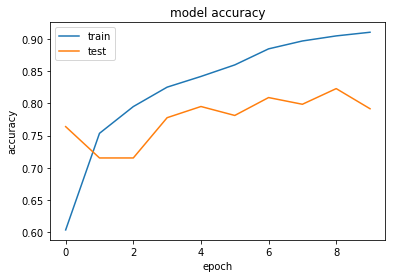

In [5]:
#save_bottlebeck_features()
train_top_model()

In [63]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape = (128,128,3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(4, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))


Model loaded.


In [64]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

In [65]:
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [66]:
batch_size = 16

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

# fine-tune the model
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

Found 2299 images belonging to 4 classes.
Found 300 images belonging to 4 classes.
Epoch 1/50
143/143 [==============================] - 192s 1s/step - loss: 0.8966 - acc: 0.8339 - val_loss: 1.8968 - val_acc: 0.7153
Epoch 2/50
143/143 [==============================] - 195s 1s/step - loss: 0.8534 - acc: 0.8359 - val_loss: 1.9930 - val_acc: 0.7007
Epoch 3/50
143/143 [==============================] - 195s 1s/step - loss: 0.9177 - acc: 0.8261 - val_loss: 1.7169 - val_acc: 0.7254
Epoch 4/50
143/143 [==============================] - 254s 2s/step - loss: 0.8722 - acc: 0.8313 - val_loss: 2.0761 - val_acc: 0.7077
Epoch 5/50
143/143 [==============================] - 259s 2s/step - loss: 0.8771 - acc: 0.8392 - val_loss: 1.6804 - val_acc: 0.7324
Epoch 6/50
143/143 [==============================] - 284s 2s/step - loss: 0.8391 - acc: 0.8398 - val_loss: 2.0833 - val_acc: 0.6796
Epoch 7/50
143/143 [==============================] - 295s 2s/step - loss: 0.8432 - acc: 0.8398 - val_loss: 1.8457 - va

KeyboardInterrupt: 

In [47]:
model.output_shape[1:]

(None, None, 512)